# Importing Libraries😊😊

In [ ]:
# ! sudo apt install fluidsynth
# ! pip install midi2audio
# ! git clone https://github.com/jude7733/BeetZart.git
# ! pip install mido

In [ ]:
from music21 import converter, instrument, note, chord
from midi2audio import FluidSynth
import wave
import numpy as np
from scipy.io.wavfile import write
import librosa
import mido
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Function to convert MIDI to Raw audio

In [ ]:
# Load MIDI files and convert to raw audio
def load_midi_to_audio(midi_file):
    # Create a synthesizer
    fs = FluidSynth()

    # Convert the MIDI file to an audio file
    audio_file = 'output.wav'
    fs.midi_to_audio(midi_file, audio_file)

    # Open the audio file and read the raw audio data
    with wave.open(audio_file, 'rb') as wave_file:
        raw_audio_data = wave_file.readframes(wave_file.getnframes())

    # Return the raw audio data
    return raw_audio_data

# Functions to create Spectrogram

In [ ]:
# Create spectrograms using short-time Fourier transform
def create_stft_spectrogram(audio, window_size, hop_length):
    stft = librosa.stft(audio, window=window_size, hop_length=hop_length)
    spectrogram = np.abs(stft)
    return spectrogram


In [ ]:
# Create spectrograms using constant-Q transform
def create_cqt_spectrogram(audio, hop_length):
    cqt = librosa.cqt(audio, hop_length=hop_length)
    spectrogram = np.abs(cqt)
    return spectrogram


# Audio and MIDI splitting

In [ ]:
# Split audio and MIDI into one-second windows
def split_into_one_second_windows(audio, midi, sample_rate):
    num_windows = int(len(audio) / sample_rate)
    audio_windows = []
    midi_windows = []
    for i in range(num_windows):
        start = i * sample_rate
        end = start + sample_rate
        audio_windows.append(audio[start:end])
        midi_windows.append(midi[start:end])
    return audio_windows, midi_windows

In [ ]:
# Split audio and MIDI into eighth-second windows
def split_into_eighth_second_windows(audio, midi, sample_rate):
    num_windows = int(len(audio) / (sample_rate / 8))
    audio_windows = []
    midi_windows = []
    for i in range(num_windows):
        start = i * (sample_rate / 8)
        end = start + (sample_rate / 8)
        audio_windows.append(audio[start:end])
        midi_windows.append(midi[start:end])
    return audio_windows, midi_windows

# Load trainning data

In [ ]:
# Example usage
midi_file = '/content/BeetZart/maestro-v3.0.0/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi'
audio = load_midi_to_audio(midi_file)
sample_rate = 22050
# Load midi
mid = mido.MidiFile(midi_file)


- `y` : audio time series (one-dimensional NumPy floating-point array)
- `sr` : sampling rate of `y` in Hz (samples per second)

In [ ]:
y, sr = librosa.load("./output.wav")
# Compute the Short-Time Fourier Transform (STFT)
D = np.abs(librosa.stft(y))
# Convert the power spectrogram to decibel (dB) units
D_db = librosa.amplitude_to_db(D, ref=np.max)
print(D_db)

[[-57.88954  -51.745922 -50.44552  ... -56.724396 -56.90844  -59.653687]
 [-59.635376 -55.861877 -56.418625 ... -62.791557 -62.550415 -62.606735]
 [-65.10418  -70.754425 -80.       ... -80.       -80.       -72.07278 ]
 ...
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]


Text(0.5, 1.0, 'Spectrogram')

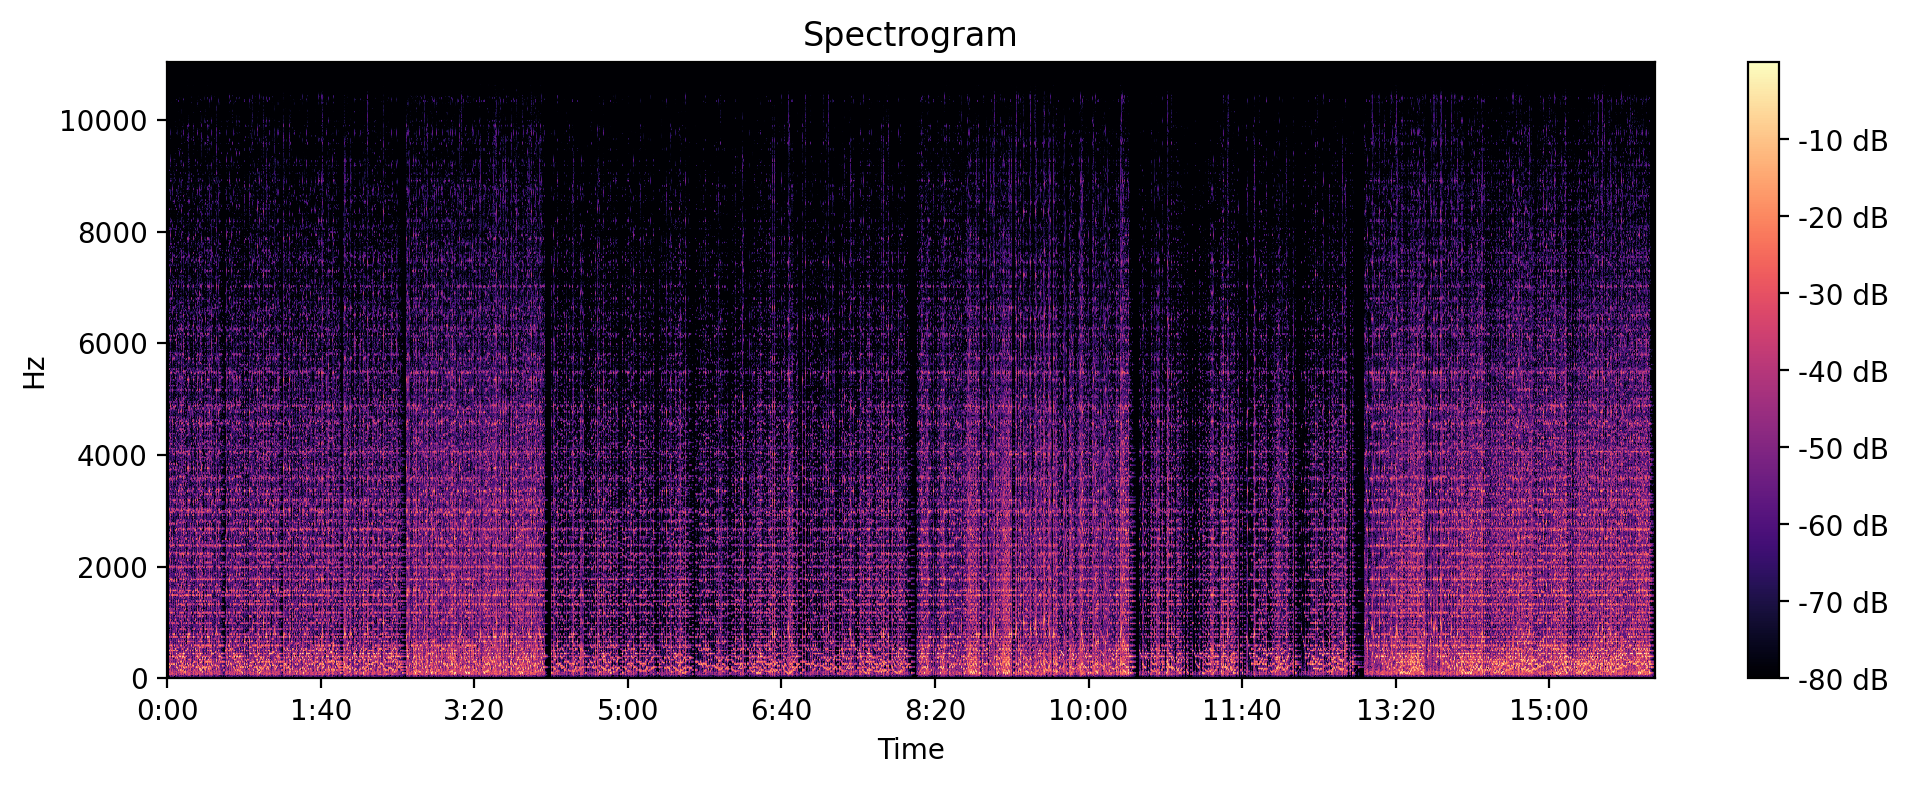

In [ ]:
plt.figure(figsize=(12,4))
librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

Mel-Frequency Cepstral Coefficients (MFCC) numpy array into frames of 20ms

In [ ]:
mfcc = librosa.feature.mfcc(S=D_db, n_mfcc=20)
print(mfcc)
mfcc.shape

[[-2.5591960e+03 -2.5591741e+03 -2.5595898e+03 ... -2.5570901e+03
  -2.5567092e+03 -2.5567754e+03]
 [ 2.9042716e+00  2.9352679e+00  2.3471370e+00 ...  5.8177290e+00
   6.3454027e+00  6.2790289e+00]
 [ 2.9041097e+00  2.9351571e+00  2.3470993e+00 ...  5.6280832e+00
   6.1241994e+00  6.1357121e+00]
 ...
 [ 2.8887610e+00  2.9246407e+00  2.3435268e+00 ...  2.0516863e+00
   1.9103124e+00  2.1191332e+00]
 [ 2.8868804e+00  2.9233518e+00  2.3430882e+00 ...  2.0652151e+00
   1.8783405e+00  2.0395241e+00]
 [ 2.8848937e+00  2.9219894e+00  2.3426247e+00 ...  2.0557041e+00
   1.8212935e+00  1.9440031e+00]]


(20, 41733)

In [ ]:
# First Frame
mfcc[:, 0]

array([-2559.196    ,     2.9042716,     2.9041097,     2.9038398,
           2.9034624,     2.9029784,     2.9023833,     2.9016821,
           2.9008732,     2.8999567,     2.8989534,     2.8978012,
           2.8965623,     2.895216 ,     2.8937628,     2.8922157,
           2.8905354,     2.888761 ,     2.8868804,     2.8848937],
      dtype=float32)

# Spectogram Creation

In [ ]:
# Create spectrograms using one-second windows
audio_windows, midi_windows = split_into_one_second_windows(audio, midi_file, sample_rate)
spectrograms = []
for audio_window in audio_windows:
    stft_spectrogram = create_stft_spectrogram(audio_window, window_size=2048, hop_length=512)
    cqt_spectrogram = create_cqt_spectrogram(audio_window, hop_length=512)
    spectrogram = np.stack([stft_spectrogram, cqt_spectrogram], axis=-1)
    spectrograms.append(spectrogram)

ParameterError: Audio data must be of type numpy.ndarray

In [ ]:
# Create spectrograms using eighth-second windows
audio_windows, midi_windows = split_into_eighth_second_windows(audio, midi_file, sample_rate)
spectrograms = []
for audio_window in audio_windows:
    stft_spectrogram = create_stft_spectrogram(audio_window, window_size=2048, hop_length=512)
    cqt_spectrogram = create_cqt_spectrogram(audio_window, hop_length=512)
    spectrogram = np.stack([stft_spectrogram, cqt_spectrogram], axis=-1)

# CNN Model definition

In [ ]:
# Train CNN on spectrograms
def train_cnn(spectrograms, labels):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=spectrograms.shape[1:]))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(spectrograms, labels, epochs=10, batch_size=32, validation_data=(val_spectrograms, val_labels))


# Trainning Model

In [ ]:
# Train CNN on one-second window spectrograms
train_cnn(np.array(spectrograms), np.array(midi_windows))

In [ ]:

# Train CNN on eighth-second window spectrograms
train_cnn(np.array(spectrograms), np.array(midi_windows))